# Capacity of the Binary-Input AWGN (BI-AWGN) Channel

This code is provided as supplementary material of the lecture Channel Coding 2 - Advanced Methods.

This code illustrates
* Calculating the capacity of the binary input AWGN channel using numerical integration
* Capacity as a function of $E_s/N_0$ and $E_b/N_0$

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt

In [11]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

matplotlib.rc('figure', figsize=(18, 6) )

Conditional pdf $f_{Y|X}(y|x)$ for a channel with noise variance (per dimension) $\sigma_n^2$. This is merely the Gaussian pdf with mean $x$ and variance $\sigma_n^2$

In [12]:
def f_YgivenX(y,x,sigman):
    return np.exp(-((y-x)**2)/(2*sigman**2))/np.sqrt(2*np.pi)/sigman

Output pdf $f_Y(y) = \frac12[f_{Y|X}(y|X=+1)+f_{Y|X}(y|X=-1)]$

In [13]:
def f_Y(y,sigman):
    return 0.5*(f_YgivenX(y,+1,sigman)+f_YgivenX(y,-1,sigman))

This is the function we like to integrate, $f_Y(y)\cdot\log_2(f_Y(y))$. We need to take special care of the case when the input is 0, as we defined $0\cdot\log_2(0)=0$, which is usually treated as "nan"

In [14]:
def integrand(y, sigman):
    value = f_Y(y,sigman)
    if value < 1e-20:
        return_value = 0
    else:
        return_value = value * np.log2(value)
    
    return return_value

Compute the capacity using numerical integration. We have
\begin{equation*}
C_{\text{BI-AWGN}} = -\int_{-\infty}^\infty f_Y(y)\log_2(f_Y(y))\mathrm{d}y - \frac12\log_2(2\pi e\sigma_n^2)
\end{equation*}

In [15]:
def C_BIAWGN(sigman):
    # numerical integration of the h(Y) part
    integral = integrate.quad(integrand, -np.inf, np.inf, args=(sigman))[0]
    # take into account h(Y|X)
    return -integral - 0.5*np.log2(2*np.pi*np.exp(1)*sigman**2)

This is an alternative way of calculating the capacity by approximating the integral using the Gauss-Hermite Quadrature (https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature). The Gauss-Hermite quadrature states that
\begin{equation*}
\int_{-\infty}^\infty e^{-x^2}f(x)\mathrm{d}x \approx \sum_{i=1}^nw_if(x_i)
\end{equation*}
where $w_i$ and $x_i$ are the respective weights and roots that are given by the Hermite polynomials.

We have to rearrange the integral $I = \int_{-\infty}^\infty f_Y(y)\log_2(f_Y(y))\mathrm{d}y$ a little bit to put it into a form suitable for the Gauss-Hermite quadrature
\begin{align*}
I &= \frac{1}{2}\sum_{x\in\{\pm 1\}}\int_{-\infty}^\infty f_{Y|X}(y|X=x)\log_2(f_Y(y))\mathrm{d}y \\
&= \frac{1}{2}\sum_{x\in\{\pm 1\}}\int_{-\infty}^\infty \frac{1}{\sqrt{2\pi}\sigma_n}e^{-\frac{(y-x)^2}{2\sigma_n^2}}\log_2(f_Y(y))\mathrm{d}y \\
&\stackrel{(a)}{=} \frac{1}{2}\sum_{x\in\{\pm 1\}}\int_{-\infty}^\infty \frac{1}{\sqrt{\pi}}e^{-z^2}\log_2(f_Y(\sqrt{2}\sigma_n z + x))\mathrm{d}z \\
&\approx \frac{1}{2\sqrt{\pi}}\sum_{x\in\{\pm 1\}} \sum_{i=1}^nw_i \log_2(f_Y(\sqrt{2}\sigma_n x_i + x))
\end{align*}
where in $(a)$, we substitute $z = \frac{y-x}{\sqrt{2}\sigma}$

In [16]:
# alternative method using Gauss-Hermite Quadrature (see https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature) 
# use 40 components to approximate the integral, should be sufficiently exact
x_GH, w_GH = np.polynomial.hermite.hermgauss(40)

def C_BIAWGN_GH(sigman):
    integral_xplus1 = np.sum(w_GH * [np.log2(f_Y(np.sqrt(2)*sigman*xi + 1, sigman)) for xi in x_GH])
    integral_xminus1 = np.sum(w_GH * [np.log2(f_Y(np.sqrt(2)*sigman*xi - 1, sigman)) for xi in x_GH])

    integral = (integral_xplus1 + integral_xminus1)/2/np.sqrt(np.pi)
    return -integral - 0.5*np.log2(2*np.pi*np.exp(1)*sigman**2)
    

Compute the capacity for a range of of $E_s/N_0$ values (given in dB)

In [17]:
esno_dB_range = np.linspace(-16,10,100)

# convert dB to linear
esno_lin_range = [10**(esno_db/10) for esno_db in esno_dB_range]

# compute sigma_n
sigman_range = [np.sqrt(1/2/esno_lin) for esno_lin in esno_lin_range]

capacity_BIAWGN = [C_BIAWGN(sigman) for sigman in sigman_range]


# capacity of the AWGN channel
capacity_AWGN = [0.5*np.log2(1+1/(sigman**2)) for sigman in sigman_range]

Plot the capacity curves as a function of $E_s/N_0$ (in dB) and $E_b/N_0$ (in dB). In order to calculate $E_b/N_0$, we recall from the lecture that
\begin{equation*}
\frac{E_s}{N_0} = r\cdot \frac{E_b}{N_0}\qquad\Rightarrow\qquad\frac{E_b}{N_0} = \frac{1}{r}\cdot \frac{E_s}{N_0}
\end{equation*}
Next, we know that the best rate that can be achieved is the capacity, i.e., $r=C$. Hence, we get $\frac{E_b}{N_0}=\frac{1}{C}\cdot\frac{E_s}{N_0}$. Converting to decibels yields
\begin{align*}
\frac{E_b}{N_0}\bigg|_{\textrm{dB}} &= 10\cdot\log_{10}\left(\frac{1}{C}\cdot\frac{E_s}{N_0}\right) \\
&= 10\cdot\log_{10}\left(\frac{1}{C}\right) + 10\cdot\log_{10}\left(\frac{E_s}{N_0}\right) \\
&= \frac{E_s}{N_0}\bigg|_{\textrm{dB}} - 10\cdot\log_{10}(C)
\end{align*}

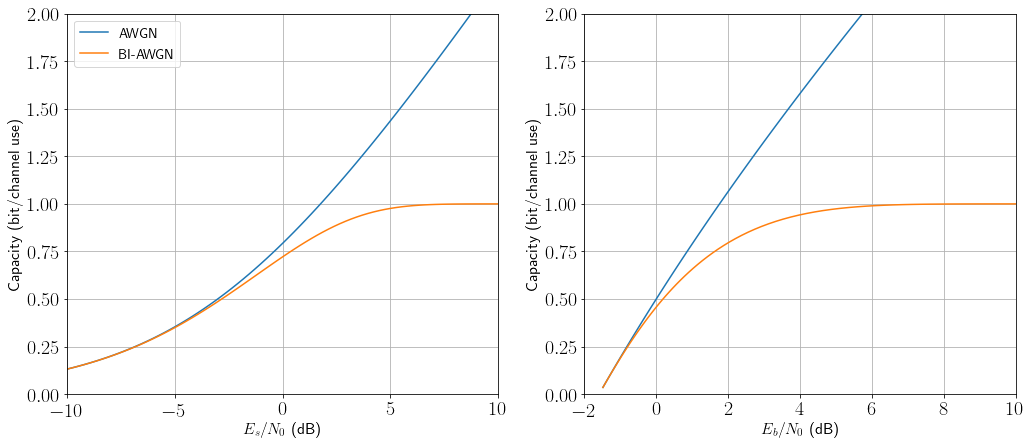

In [18]:
fig = plt.figure(1,figsize=(17,7))
plt.subplot(121)
plt.plot(esno_dB_range, capacity_AWGN)
plt.plot(esno_dB_range, capacity_BIAWGN)
plt.xlim((-10,10))
plt.ylim((0,2))
plt.xlabel('$E_s/N_0$ (dB)',fontsize=16)
plt.ylabel('Capacity (bit/channel use)',fontsize=16)
plt.grid(True)
plt.legend(['AWGN','BI-AWGN'],fontsize=14)


# plot Eb/N0 . Note that in this case, the rate that is used for calculating Eb/N0 is the capcity
# Eb/N0 = 1/r (Es/N0)
plt.subplot(122)
plt.plot(esno_dB_range - 10*np.log10(capacity_AWGN), capacity_AWGN)
plt.plot(esno_dB_range - 10*np.log10(capacity_BIAWGN), capacity_BIAWGN)
plt.xlim((-2,10))
plt.ylim((0,2))
plt.xlabel('$E_b/N_0$ (dB)',fontsize=16)
plt.ylabel('Capacity (bit/channel use)',fontsize=16)
plt.grid(True)

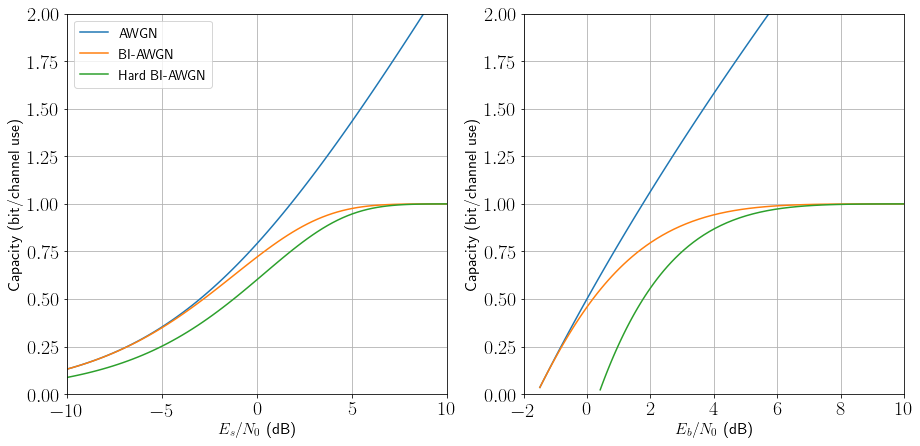

In [19]:
from scipy.stats import norm
# first compute the BSC error probability
# the Q function (1-CDF) is also often called survival function (sf)
delta_range = [norm.sf(1/sigman) for sigman in sigman_range]

capacity_BIAWGN_hard = [1+delta*np.log2(delta)+(1-delta)*np.log2(1-delta) for delta in delta_range]


fig = plt.figure(1,figsize=(15,7))
plt.subplot(121)
plt.plot(esno_dB_range, capacity_AWGN)
plt.plot(esno_dB_range, capacity_BIAWGN)
plt.plot(esno_dB_range, capacity_BIAWGN_hard)
plt.xlim((-10,10))
plt.ylim((0,2))
plt.xlabel('$E_s/N_0$ (dB)',fontsize=16)
plt.ylabel('Capacity (bit/channel use)',fontsize=16)
plt.grid(True)
plt.legend(['AWGN','BI-AWGN', 'Hard BI-AWGN'],fontsize=14)

# plot Eb/N0 . Note that in this case, the rate that is used for calculating Eb/N0 is the capcity
# Eb/N0 = 1/r (Es/N0)
plt.subplot(122)
plt.plot(esno_dB_range - 10*np.log10(capacity_AWGN), capacity_AWGN)
plt.plot(esno_dB_range - 10*np.log10(capacity_BIAWGN), capacity_BIAWGN)
plt.plot(esno_dB_range - 10*np.log10(capacity_BIAWGN_hard), capacity_BIAWGN_hard)

plt.xlim((-2,10))
plt.ylim((0,2))
plt.xlabel('$E_b/N_0$ (dB)',fontsize=16)
plt.ylabel('Capacity (bit/channel use)',fontsize=16)
plt.grid(True)